# SP500 Backtesting Result (Short selling is allowed)

## Introduction
This notebook essentially mimic the process have done in the DJIA case.

This whole Jupyter Notebook will be divided into 3 parts. Breif summary of each part is shown as follows:
* Part 1: Import required libraries, import SP500 price data and risk free information, defined several functions
* Part 2: Import modeling dataset, modeling and produce backtesting report
* Part 3: Discussions of potential ways for improving the result

## Key Assumptions
1. Short selling is allowed.
2. All transaction cost, slippages are assumed to be 0, implied the market is frictionless.
3. Treat SP500 as something like a stock and the price is just the index level.
4. The initial investment is 100000

## Performance Calculation
1. Assume trading days for a year is 252.
2. Use 13 week US Treasury bill rate as risk free rate (converted to daily rate).
3. Sharpe ratio is calculated on a yearly basis.
4. Maximum drawdown is calculated based on the whole period, not in the rolling window format. 

## Part 1: Pre-modeling Set up

### 1.1 Import required libraries

In [1]:
# Import required libraries
import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import quandl
from datetime import date

from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc,precision_score, accuracy_score, recall_score, f1_score
from scipy import interp
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

pd.options.mode.chained_assignment = None

In [2]:
# List to keep different methods scores to compare
ScoreSummaryByMethod=[]
FillAtClosePrice=[]
FillAtOpenPrice=[]

### 1.2 Import SP500 data and risk free rate

In [3]:
# Import SP500 data and risk free rate
SP500=pd.read_excel('/Users/chester/Desktop/Peter_project/raw_data/SP500_table.xlsx')
SP500['Date']=pd.to_datetime(SP500['Date'])

### 1.3 Define several functions for further use
* text_process: text pre-processing
* ROCCurves: generate ROC curves
* heatmap: plot function
* plot_classification_report
* plot_confusion_matrix
* Evaluation: main function for evaluting the model, return AUC and other ket information
* **create_port**: create a portfolio for backtesting
* **backtest_close**: backtesting assume filling at T+0 adj close price
* **backtest_open**: backtesting assume filling at T+1 open price
* **performance**: generate performance report which indicates annualized return, annualized volatility, annualized Sharpe ratio, maximum drawdown

In [4]:
# Text pre-processing

def text_process(text):
    """
    Takes in a string of text, then performs the following:
    1. Tokenizes and removes punctuation
    2. Removes  stopwords
    3. Stems
    4. Returns a list of the cleaned text
    """
    if pd.isnull(text):
        return []
    # tokenizing
    tokenizer = RegexpTokenizer(r'\w+')
    text_processed=tokenizer.tokenize(text)
    
    # removing any stopwords
    text_processed = [word.lower() for word in text_processed if word.lower() not in stopwords.words('english')]
    
    # steming
    porter_stemmer = PorterStemmer()
    
    text_processed = [porter_stemmer.stem(word) for word in text_processed]
    
    try:
        text_processed.remove('b')
    except: 
        pass

    return text_processed

In [5]:
# ROC curve generation

def ROCCurves (Actual, Predicted):
    '''
    Plot ROC curves for the multiclass problem
    based on http://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html
    '''
    # Compute ROC curve and ROC area for each class
    n_classes=2
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(Actual.values, Predicted)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(Actual.ravel(), Predicted.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    ##############################################################################
    # Plot ROC curves for the multiclass problem

    # Compute macro-average ROC curve and ROC area

    # First aggregate all false positive rates

    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Plot all ROC curves
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         linewidth=2)

    plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)

    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                   ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")

In [6]:
def heatmap(data, rotate_xticks=True):
  fig, ax = plt.subplots()
  heatmap = sns.heatmap(data, cmap=plt.cm.Blues)
  ax.xaxis.tick_top()
  if rotate_xticks:
      plt.xticks(rotation=90)
  plt.yticks(rotation=0)

In [7]:
def plot_classification_report(classification_report):
    lines = classification_report.split('\n')
    classes = []
    plotMat = []
    for line in lines[2 : (len(lines) - 3)]:
        t = line.split()
        classes.append(t[0])
        v = [float(x) for x in t[1: len(t) - 1]]
        plotMat.append(v)
    aveTotal = lines[len(lines) - 1].split()
    classes.append('avg/total')
    vAveTotal = [float(x) for x in t[1:len(aveTotal) - 1]]
    plotMat.append(vAveTotal)
    df_classification_report = DataFrame(plotMat, index=classes,columns=['precision', 'recall', 'f1-score'])
    heatmap(df_classification_report)

In [8]:
def plot_confusion_matrix(confusion_matrix,classes=['0','1']):
    df_confusion_matrix = DataFrame(confusion_matrix, index=classes,columns=classes)
    heatmap(df_confusion_matrix,False)

In [9]:
def Evaluation (Method,Comment,Actual, Predicted):
    '''
        Prints and plots
        - classification report
        - confusion matrix
        - ROC-AUC
    '''
    print (Method)
    print (Comment)
    print (classification_report(Actual,Predicted))
    #plot_classification_report(classification_report(Actual,Predicted))
    print ('Confussion matrix:\n', confusion_matrix(Actual,Predicted))
    #plot_confusion_matrix(confusion_matrix(Actual,Predicted))
    ROC_AUC=roc_auc_score(Actual,Predicted)
    print ('ROC-AUC: ' + str(ROC_AUC))
    #ROCCurves (Actual,Predicted)
    Precision=precision_score(Actual,Predicted)
    Accuracy=accuracy_score(Actual,Predicted)
    Recall=recall_score(Actual,Predicted)
    F1=f1_score(Actual,Predicted)
    ScoreSummaryByMethod.append([Method,Comment,ROC_AUC,Precision,Accuracy,Recall,F1])

In [10]:
# create a portfolio
def create_port(result):
    port=pd.merge(result,SP500,how='left',on='Date')[['Date','Open','Adj Close','Label','predict']]
    port['shares hold']=0
    port['PnL']=0
    port['wealth']=0
    port['wealth'][0]=100000
    return port

In [11]:
# Backtest, assume fill at t+0 adjusted close price
# default slippage=0, transaction cost=0
def backtest_close(port):
    #handle the starting day
    if port.loc[0,'predict']==1:
        port.loc[0,'shares hold']=port.loc[0,'wealth']/port.loc[0,'Adj Close']
    if port.loc[0,'predict']==0:
        port.loc[0,'shares hold']=-port.loc[0,'wealth']/port.loc[0,'Adj Close']
    #handle the following days
    for i in range(1,port.index[-1]+1):
        if port.loc[i-1,'shares hold']==0:
            if port.loc[i,'predict']==1: # this is a buy signal
                port.loc[i,'shares hold']=port.loc[i-1,'wealth']/port.loc[i,'Adj Close']
                port.loc[i,'wealth']=port.loc[i,'shares hold']*port.loc[i,'Adj Close']
            if port.loc[i,'predict']==0: # this is a short signal
                port.loc[i,'shares hold']=-port.loc[i-1,'wealth']/port.loc[i,'Adj Close']
                port.loc[i,'wealth']=-port.loc[i,'shares hold']*port.loc[i,'Adj Close']
        if port.loc[i-1,'shares hold']>0: # hold some shares
            if port.loc[i,'predict']==1: # hold since we have shares in hand
                port.loc[i,'shares hold']=port.loc[i-1,'shares hold']
                port.loc[i,'PnL']=port.loc[i,'shares hold']*(port.loc[i,'Adj Close']-port.loc[i-1,'Adj Close'])
                port.loc[i,'wealth']=port.loc[i-1,'wealth']+port.loc[i,'PnL']
            if port.loc[i,'predict']==0: # this is a sell signal (close position)
                #close the position
                port.loc[i,'shares hold']=0
                port.loc[i,'PnL']=port.loc[i-1,'shares hold']*(port.loc[i,'Adj Close']-port.loc[i-1,'Adj Close'])
                port.loc[i,'wealth']=port.loc[i-1,'wealth']+port.loc[i,'PnL']
        if port.loc[i-1,'shares hold']<0:
            if port.loc[i,'predict']==1: # close position
                port.loc[i,'shares hold']=0
                port.loc[i,'PnL']=port.loc[i-1,'shares hold']*(port.loc[i,'Adj Close']-port.loc[i-1,'Adj Close'])
                port.loc[i,'wealth']=port.loc[i-1,'wealth']+port.loc[i,'PnL']
            if port.loc[i,'predict']==0:
                port.loc[i,'shares hold']=port.loc[i-1,'shares hold']
                port.loc[i,'PnL']=port.loc[i-1,'shares hold']*(port.loc[i,'Adj Close']-port.loc[i-1,'Adj Close'])
                port.loc[i,'wealth']=port.loc[i-1,'wealth']+port.loc[i,'PnL']
    port['return']=port['wealth'].pct_change()
    return port[['Date','shares hold','PnL','wealth','return']]

In [12]:
# Backtest, assume fill at t+1 open price
# default slippage=0, transaction cost=0, interest=0
def backtest_open(port):
    for i in range(0,port.index[-1]):
        if port.loc[i,'shares hold']==0: #position at i is 0
            if port.loc[i,'predict']==1: #prediction at i is 1, this is a buy signal
                #wealth at i will not change, but the shares hold at i+1 will change, shares hold(i+1)=wealth(i)/Open(i+1)
                port.loc[i+1,'shares hold']=port.loc[i,'wealth']/port.loc[i+1,'Open']
                #wealth(i+1) will be shares hold(i+1)*Open(i+2)
                port.loc[i+1,'wealth']=port.loc[i+1,'shares hold']*port.loc[i+1,'Open']
            if port.loc[i,'predict']==0: #prediction at i is 0, this is a short signal
                port.loc[i+1,'shares hold']=-port.loc[i,'wealth']/port.loc[i+1,'Open']
                port.loc[i+1,'wealth']=port.loc[i,'wealth']
        if port.loc[i,'shares hold']>0: #position at i is not 0
            if port.loc[i,'predict']==1: #prediction at i is 1, just hold the shares for i+1
                # shares at i+1 is the same as shares at i
                port.loc[i+1,'shares hold']=port.loc[i,'shares hold']
                port.loc[i+1,'PnL']=(port.loc[i+1,'Open']-port.loc[i,'Open'])*port.loc[i,'shares hold']
                port.loc[i+1,'wealth']=port.loc[i,'wealth']+port.loc[i+1,'PnL']
            if port.loc[i,'predict']==0: #prediction at i is 0, this is a sell signal (close position)
                # shares at i+1 should be 0
                port.loc[i+1,'shares hold']=0
                port.loc[i+1,'PnL']=(port.loc[i+1,'Open']-port.loc[i,'Open'])*port.loc[i,'shares hold']
                port.loc[i+1,'wealth']=port.loc[i,'wealth']+port.loc[i+1,'PnL']
        if port.loc[i,'shares hold']<0: #position at i is not 0
            if port.loc[i,'predict']==1: #prediction at i is 1, just hold the shares for i+1
                port.loc[i+1,'shares hold']=0
                port.loc[i+1,'PnL']=(port.loc[i+1,'Open']-port.loc[i,'Open'])*port.loc[i,'shares hold']
                port.loc[i+1,'wealth']=port.loc[i,'wealth']+port.loc[i+1,'PnL']
            if port.loc[i,'predict']==0:
                port.loc[i+1,'shares hold']=port.loc[i,'shares hold']
                port.loc[i+1,'PnL']=(port.loc[i+1,'Open']-port.loc[i,'Open'])*port.loc[i,'shares hold']
                port.loc[i+1,'wealth']=port.loc[i,'wealth']+port.loc[i+1,'PnL']
    port['return']=port['wealth'].pct_change()
    return port[['Date','shares hold','PnL','wealth','return']]

In [13]:
#report annualized return, volatility and Sharpe ratio
def performance(Method, Comment, fill_type, port,N=252):
    #default number of a year is N=252
    print("Classification method: ",Method)
    print("Paremeters choose: ", Comment)
    print("Order fill type: ", fill_type)
    #annualized mean of return
    annual_return=N*port['return'].mean()
    #annulized standard deviation
    annual_sd=np.sqrt(N)*port['return'].std()
    #annualized sharpe ratio
    #use 13-week US Treasury bill rate as risk free rate (benchmark)
    daily_sharpe=port['return'].mean() / port['return'].std()
    annual_sharpe=np.sqrt(N) * daily_sharpe
    
    hwm=[0.0]
    idx=port.index
    drawdown=pd.DataFrame(port['Date'])
    drawdown['dd']=0.0
    for i in range(1,len(idx)):
        current_hwm=max(hwm[i-1],port['wealth'][i])
        hwm.append(current_hwm)
        drawdown['dd'][i]=float((hwm[i]-port['wealth'][i]))/float(hwm[i])
    max_drawdown=drawdown['dd'].max()
    print("The annualized return is "+"{:.4%}".format(annual_return))
    print("The annualized volatility is "+"{:.4%}".format(annual_sd))
    print("The annualized Sharpe ratio is "+"{:.4}".format(annual_sharpe))
    print("The maximum drawdown during backtesting period is "+"{:.4%}".format(max_drawdown))
    
    #Create the performance plots
    '''
    fig,axes=plt.subplots(nrows=3,ncols=1,figsize=(6,4))
    axes[0].plot(port['Date'],port['wealth'])
    axes[0].set_title('Wealth curve')
    axes[1].plot(port['Date'],port['return'])
    axes[1].set_title('Return')
    axes[2].plot(drawdown['Date'], drawdown['dd'])
    axes[2].set_title('Drawdown')
    plt.tight_layout()
    fig.autofmt_xdate()
    '''
    
    port.plot('Date','wealth')
    port.plot('Date','return')
    drawdown.plot('Date','dd')
    if fill_type=='close':
        FillAtClosePrice.append([Method, Comment, annual_return, annual_sd, annual_sharpe,max_drawdown])
    if fill_type=='open':
        FillAtOpenPrice.append([Method, Comment, annual_return, annual_sd, annual_sharpe,max_drawdown])

## Part 2: Modeling and backtesting
The main task in this section is to model and backtest the strategy. The basic flow is:
1. Import modeling dataset
2. Combine predictions with SP500 dataset and backtesting the strategy by assuming filling at T+0 adjusted close price and T+1 open price respectively
3. Report the annulized return, annualized volatility, annualized Sharpe ratio and maximum drawdown

I will examine the following methods:
1. Baseline classifier: Naive Bayes classifier, no n-gram, no shift, combined all top news
2. Bernoulli Naive Bayes classifier, n-grams, alpha=1, no shift, combined all top news
3. Bernoulli Naive Bayes classifier, 1-2 n-grams, alpha=0.1, 1-day shift, combined all top news
4. Bernoulli Naive Bayes classifier, 1-2 n-grams, alpha=0.5, 3-day shift, combined all top news
5. Bernoulli Naive Bayes classifier, 1-2 n-grams, alpha=0.5, 2-day shift, combined top3,top12 and top25 news

The comparison results are stores in the following tables:
1. df_ScoreSummaryByMethod: modeling scores for different methods
2. df_FillAtClosePrice: performance for different methods assuming filling at T+0 adjusted close price
3. df_FillAtOpenPrice: performance for different methods assuming filling at T+1 open price
The latter 2 tables are sorted by Sharpe ratio in descending order.


### Baseline classifier

In [14]:
#Creating a Data Pipeline for Naive Bayes classifier classifier - baseline
# Import raw modeling dataset and split into train and test datasets
df=pd.read_excel('/Users/chester/Desktop/Peter_project/raw_data/Combined_News_SP500.xlsx')
df['Combined']=df.iloc[:,2:27].apply(lambda row: ''.join(str(row.values)), axis=1)
df.head()
# Split the dataset into train data and test data
# Train data
train=df.loc[(pd.to_datetime(df["Date"]) <= date(2014,12,31)),['Label','Date','Combined']]
# Test data
test=df.loc[(pd.to_datetime(df["Date"]) > date(2014,12,31)),['Label','Date','Combined']]
nb_pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])
nb_pipeline.fit(train['Combined'],train['Label'])
predictions = nb_pipeline.predict(test['Combined'])
test['predict']=predictions
test['Date']=pd.to_datetime(test['Date'])
Evaluation ('MultinomialNB','no shift, no n-grams, combined Top news',test["Label"], predictions)

MultinomialNB
no shift, no n-grams, combined Top news
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       191
          1       0.49      1.00      0.66       187

avg / total       0.24      0.49      0.33       378

Confussion matrix:
 [[  0 191]
 [  0 187]]
ROC-AUC: 0.5


/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Note that in this case, which is to use today's top news to forecast today's stock price, is not useful since essentially, if based on today's news, the forecast is that it will go up today. If you don't have a position, then you need to buy at today, which implies that you believe the price also go up tomorrow. Of course, if you already had a position, then this strategy may work since essentially, if you has a long position and the predict is up, then you can just keep the position.

### Bernoulli Naive Bayes classifier, n-grams, alpha=1, no shift, combined all top news

In [15]:
#Creating a Data Pipeline for Bernoulli Naive Bayes classifier classifier and n-grams, default alpha=1
bnb_2ngram_pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process,ngram_range=(1, 2))),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', BernoulliNB(binarize=0.0)),  # train on TF-IDF vectors w/ Bernoulli Naive Bayes classifier
])
bnb_2ngram_pipeline.fit(train['Combined'],train['Label'])
predictions = bnb_2ngram_pipeline.predict(test['Combined'])
test['predict']=predictions
test['Date']=pd.to_datetime(test['Date'])
Evaluation ('BernoulliNB(binarize=0.0)','default alpha=1,no shift, ngram_range=(1, 2), combined Top news',test["Label"], predictions)

BernoulliNB(binarize=0.0)
default alpha=1,no shift, ngram_range=(1, 2), combined Top news
             precision    recall  f1-score   support

          0       0.37      0.14      0.20       191
          1       0.46      0.76      0.58       187

avg / total       0.42      0.45      0.39       378

Confussion matrix:
 [[ 26 165]
 [ 44 143]]
ROC-AUC: 0.450415768402


Similar to the above case, it is not so useful since you are not predict tommorows's up and down movement, but today's.

### Bernoulli Naive Bayes classifier, 1-2 n-grams, alpha=0.1, 1-day shift, combined all top news

Now, we will use the news in day i to make prediction for day i+1. In this case, I will backtest the following strategy:
1. Assume fill at T+0 adjusted close price:
    * If we do not have position in previous day (day i-1) and if the prediction is 1, we invest all of our money in the SP500, else (the prediction is 0), we short the amount of shares that we can long at that day's adjusted close price. 
    * If we have positive position (long) in previous day (day i-1) and if the prediction is 0, we clear our position at that day's adjusted close price, else (the prediction is 1), we just hold the shares. 
    * If we have negative position (short) in previous day (day i-1) and if the prediction is 0, we hold the short position and if the prediction, we close the position by buying at the adjusted close price of that day.
2. Assume fill at T+1 open price:
    * If we do not have position in day i and if the prediction is 1, we invest all of our money in the SP500 at the open price of day i+1, else (the prediction is 0), short the amount of shares that we can long at the open price of day i+1. 
    * If we have positive (long) position in SP500 at day i and if the prediction is 0, we close our position at day i+1's open price, else (the prediction is 1), we just hold the shares. 
    * If we have short position in SP500 at day i and if the prediction is 1, we close our position at day i+1's open price, else (the prediction is 0), we just hold the short position. 

In [16]:
#1 days shift
df=pd.read_excel('/Users/chester/Desktop/Peter_project/raw_data/Combined_News_SP500.xlsx')
df.Label = df.Label.shift(-1)
df.drop(df.index[len(df)-1], inplace=True)
df['Combined']=df.iloc[:,2:27].apply(lambda row: ''.join(str(row.values)), axis=1)
train=df.loc[(pd.to_datetime(df["Date"]) <= date(2014,12,31)),['Label','Date','Combined']]
test=df.loc[(pd.to_datetime(df["Date"]) > date(2014,12,31)),['Label','Date','Combined']]

In [17]:
#The best result for Bernoulli Naive Bayes classifier, 1-2 n-grams and 1-day shift is smoothing alpha = 0 
# Update: alpha=0 can not generate the desired result, try alpha=0.1
bnb_2ngram_pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process,ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer()), 
    ('classifier', BernoulliNB(alpha=0.1, binarize=0.0))])
bnb_2ngram_pipeline.fit(train['Combined'],train['Label'])
predictions = bnb_2ngram_pipeline.predict(test['Combined'])
test['predict']=predictions
test['Date']=pd.to_datetime(test['Date'])
Evaluation ('BernoulliNB(alpha=0.1,binarize=0.0)','1-day shift, ngram_range=(1, 2), combined Top news',test["Label"], predictions)

BernoulliNB(alpha=0.1,binarize=0.0)
1-day shift, ngram_range=(1, 2), combined Top news
             precision    recall  f1-score   support

        0.0       0.54      0.34      0.42       190
        1.0       0.51      0.70      0.59       187

avg / total       0.52      0.52      0.50       377

Confussion matrix:
 [[ 65 125]
 [ 56 131]]
ROC-AUC: 0.521320011258


Classification method:  BernoulliNB(alpha=0.1,binarize=0.0)
Paremeters choose:  1-day shift, ngram_range=(1, 2), combined Top news
Order fill type:  close
The annualized return is -5.3243%
The annualized volatility is 13.1917%
The annualized Sharpe ratio is -0.4036
The maximum drawdown during backtesting period is 19.1895%


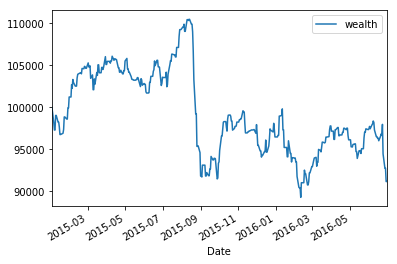

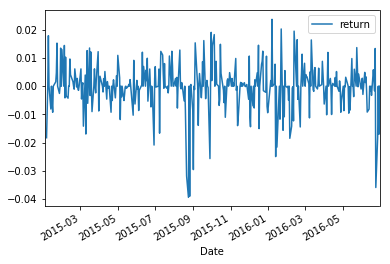

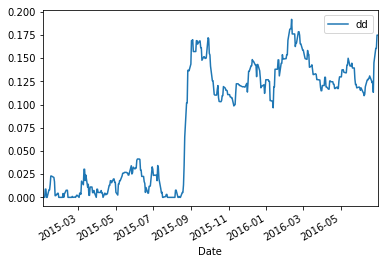

In [18]:
portfolio=create_port(test)
result_close=backtest_close(portfolio)
performance('BernoulliNB(alpha=0.1,binarize=0.0)','1-day shift, ngram_range=(1, 2), combined Top news','close',result_close)

Classification method:  BernoulliNB(alpha=0.1,binarize=0.0)
Paremeters choose:  1-day shift, ngram_range=(1, 2), combined Top news
Order fill type:  open
The annualized return is -3.9241%
The annualized volatility is 12.2072%
The annualized Sharpe ratio is -0.3215
The maximum drawdown during backtesting period is 18.5950%


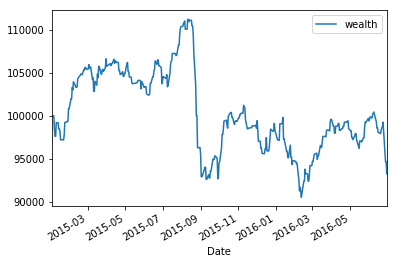

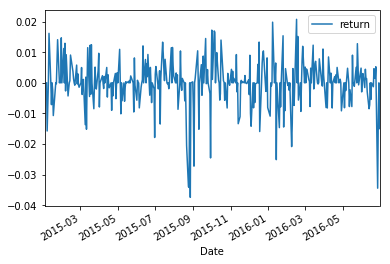

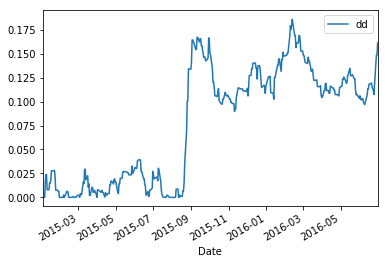

In [19]:
portfolio=create_port(test)
result_open=backtest_open(portfolio)
performance('BernoulliNB(alpha=0.1,binarize=0.0)','1-day shift, ngram_range=(1, 2), combined Top news','open',result_open)

### Bernoulli Naive Bayes classifier, 1-2 n-grams, alpha=0.5, 3-day shift, combined all top news
Note that in this case, we are going to make predictions for day i+3 based on the news on day i. We can develop three different strtagies baseon when we make the decision, i.e. we can make decision on day i, day i+1 or day i+2.

In [20]:
#3 days shift
df=pd.read_excel('/Users/chester/Desktop/Peter_project/raw_data/Combined_News_SP500.xlsx')
df.Label = df.Label.shift(-3)
df.drop(df.index[len(df)-1], inplace=True)
df.drop(df.index[len(df)-1], inplace=True)
df.drop(df.index[len(df)-1], inplace=True)
df['Combined']=df.iloc[:,2:27].apply(lambda row: ''.join(str(row.values)), axis=1)
train=df.loc[(pd.to_datetime(df["Date"]) <= date(2014,12,31)),['Label','Date','Combined']]
test=df.loc[(pd.to_datetime(df["Date"]) > date(2014,12,31)),['Label','Date','Combined']]

In [21]:
bnb_2ngram_pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process,ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer()), 
    ('classifier', BernoulliNB(alpha=0.5, binarize=0.0))])
bnb_2ngram_pipeline.fit(train['Combined'],train['Label'])
predictions = bnb_2ngram_pipeline.predict(test['Combined'])
test['predict']=predictions
test['Date']=pd.to_datetime(test['Date'])
Evaluation ('BernoulliNB(alpha=0.5,binarize=0.0)','3-days shift, ngram_range=(1, 2), combined Top news',test["Label"], predictions)

BernoulliNB(alpha=0.5,binarize=0.0)
3-days shift, ngram_range=(1, 2), combined Top news
             precision    recall  f1-score   support

        0.0       0.53      0.37      0.44       188
        1.0       0.52      0.68      0.59       187

avg / total       0.53      0.52      0.51       375

Confussion matrix:
 [[ 69 119]
 [ 60 127]]
ROC-AUC: 0.523082830811


#### Strategy 1:
According to the prediction for day i+3, make the decision in day i. Which means that: on day i, predict the up or down of DJIA for day i+3, then make decision on day i.

Classification method:  BernoulliNB(alpha=0.5,binarize=0.0)
Paremeters choose:  3-days shift, ngram_range=(1, 2), combined Top news, make decision on day i
Order fill type:  close
The annualized return is -7.2023%
The annualized volatility is 13.7231%
The annualized Sharpe ratio is -0.5248
The maximum drawdown during backtesting period is 18.2663%


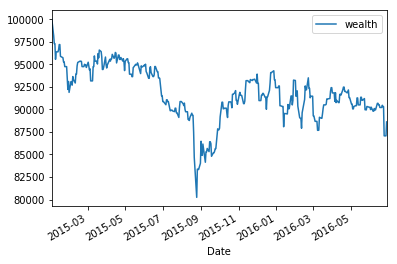

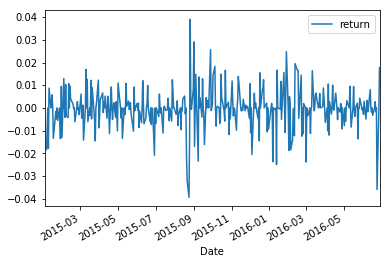

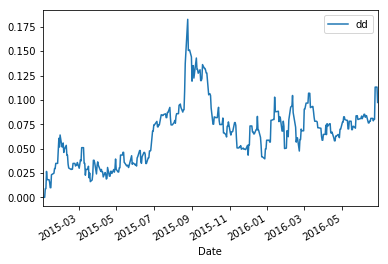

In [22]:
portfolio=create_port(test)
result_close=backtest_close(portfolio)
performance('BernoulliNB(alpha=0.5,binarize=0.0)','3-days shift, ngram_range=(1, 2), combined Top news, make decision on day i','close',result_close)

Classification method:  BernoulliNB(alpha=0.5,binarize=0.0)
Paremeters choose:  3-days shift, ngram_range=(1, 2), combined Top news, make decision on day i
Order fill type:  open
The annualized return is -7.1315%
The annualized volatility is 12.7664%
The annualized Sharpe ratio is -0.5586
The maximum drawdown during backtesting period is 17.8670%


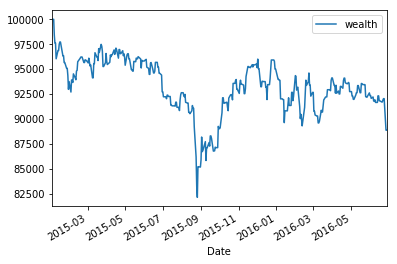

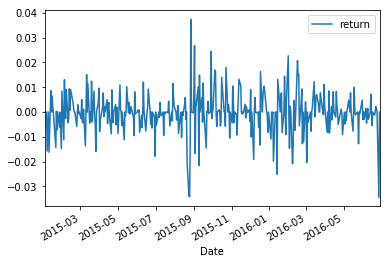

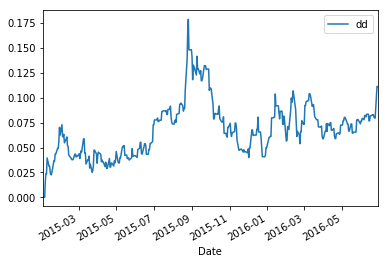

In [23]:
portfolio=create_port(test)
result_open=backtest_open(portfolio)
performance('BernoulliNB(alpha=0.5,binarize=0.0)','3-days shift, ngram_range=(1, 2), combined Top news, make decision on day i','open',result_open)

#### Strategy 2:
According to the prediction for i+3, make the decision at i+1

In [24]:
test.predict=test.predict.shift(1)
test.drop(test.index[0], inplace=True)

Classification method:  BernoulliNB(alpha=0.5,binarize=0.0)
Paremeters choose:  3-days shift, ngram_range=(1, 2), combined Top news, make decision on day i+1
Order fill type:  close
The annualized return is 4.5403%
The annualized volatility is 13.4076%
The annualized Sharpe ratio is 0.3386
The maximum drawdown during backtesting period is 15.8536%


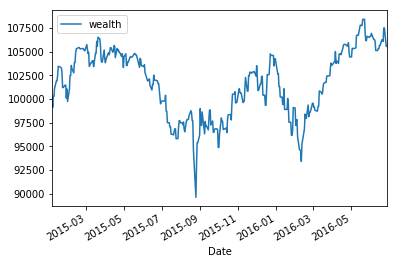

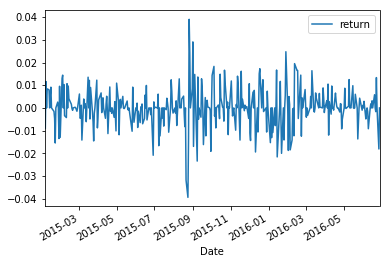

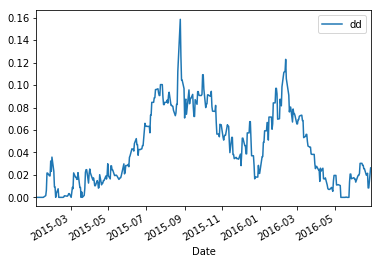

In [25]:
portfolio=create_port(test)
result_close=backtest_close(portfolio)
performance('BernoulliNB(alpha=0.5,binarize=0.0)','3-days shift, ngram_range=(1, 2), combined Top news, make decision on day i+1','close',result_close)

Classification method:  BernoulliNB(alpha=0.5,binarize=0.0)
Paremeters choose:  3-days shift, ngram_range=(1, 2), combined Top news, make decision on day i+1
Order fill type:  open
The annualized return is 4.2912%
The annualized volatility is 12.4160%
The annualized Sharpe ratio is 0.3456
The maximum drawdown during backtesting period is 14.9150%


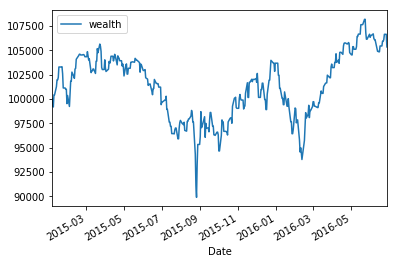

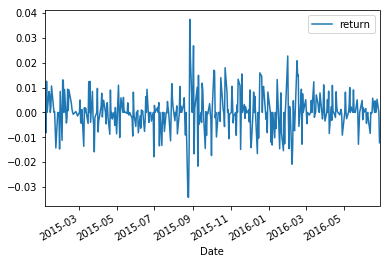

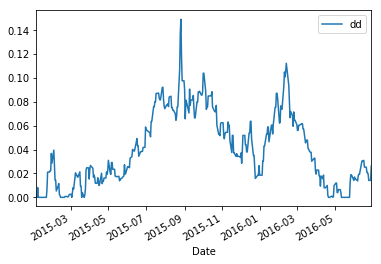

In [26]:
portfolio=create_port(test)
result_open=backtest_open(portfolio)
performance('BernoulliNB(alpha=0.5,binarize=0.0)','3-days shift, ngram_range=(1, 2), combined Top news, make decision on day i+1','open',result_open)

#### Strategy 3:
According to the prediction for i+3, make the decision at i+2

In [27]:
test.predict=test.predict.shift(1)
test.drop(test.index[0], inplace=True)

Classification method:  BernoulliNB(alpha=0.5,binarize=0.0)
Paremeters choose:  3-days shift, ngram_range=(1, 2), combined Top news, make decision on day i+2
Order fill type:  close
The annualized return is 7.2395%
The annualized volatility is 13.7092%
The annualized Sharpe ratio is 0.5281
The maximum drawdown during backtesting period is 12.1300%


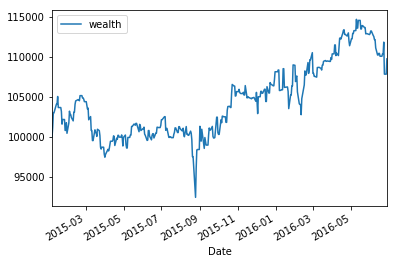

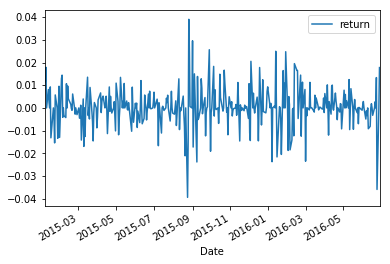

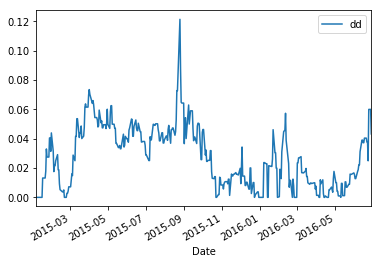

In [28]:
portfolio=create_port(test)
result_close=backtest_close(portfolio)
performance('BernoulliNB(alpha=0.5,binarize=0.0)','3-days shift, ngram_range=(1, 2), combined Top news, make decision on day i+2','close',result_close)

Classification method:  BernoulliNB(alpha=0.5,binarize=0.0)
Paremeters choose:  3-days shift, ngram_range=(1, 2), combined Top news, make decision on day i+2
Order fill type:  open
The annualized return is 5.8638%
The annualized volatility is 12.5691%
The annualized Sharpe ratio is 0.4665
The maximum drawdown during backtesting period is 11.9133%


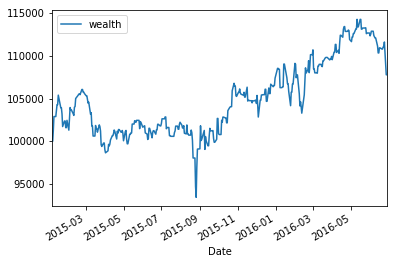

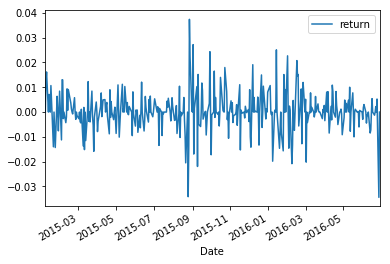

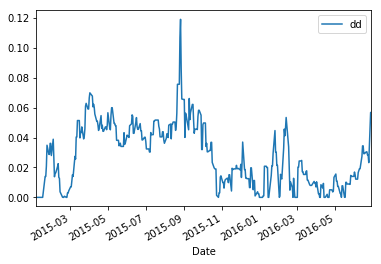

In [29]:
portfolio=create_port(test)
result_open=backtest_open(portfolio)
performance('BernoulliNB(alpha=0.5,binarize=0.0)','3-days shift, ngram_range=(1, 2), combined Top news, make decision on day i+2','open',result_open)

### Bernoulli Naive Bayes classifier, 1-2 n-grams, alpha=0.5, 2-day shift, combined top3,top12 and top25 news
Similar to the previous case, now we are going to use the news on day i to make predication for day i+2. We have two strategies based on when to make the decision, i.e. make decision on day i or day i+1.

In [30]:
#Combine top 3, 12 ,25
df=pd.read_excel('/Users/chester/Desktop/Peter_project/raw_data/Combined_News_SP500.xlsx')
df.Label = df.Label.shift(-1)
df.drop(df.index[len(df)-1], inplace=True)
df.Label = df.Label.shift(-1)
df.drop(df.index[len(df)-1], inplace=True)
df['Combined3_12_25']=df.iloc[:,[4,13,26]].apply(lambda row: ''.join(str(row.values)), axis=1)
train=df.loc[(pd.to_datetime(df["Date"]) <= date(2014,12,31)),['Label','Date','Combined3_12_25']]
test=df.loc[(pd.to_datetime(df["Date"]) > date(2014,12,31)),['Label','Date','Combined3_12_25']]
bnb_2ngram_pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process,ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer()), 
    ('classifier', BernoulliNB(alpha=0.5, binarize=0.0))])
bnb_2ngram_pipeline.fit(train['Combined3_12_25'],train['Label'])
predictions = bnb_2ngram_pipeline.predict(test['Combined3_12_25'])
test['predict']=predictions
test['Date']=pd.to_datetime(test['Date'])
Evaluation ('BernoulliNB(alpha=0.5,binarize=0.0)','2-days shift, ngram_range=(1, 2),Combined Top3,top12 and Top25',test["Label"], predictions)

BernoulliNB(alpha=0.5,binarize=0.0)
2-days shift, ngram_range=(1, 2),Combined Top3,top12 and Top25
             precision    recall  f1-score   support

        0.0       0.52      0.39      0.44       189
        1.0       0.51      0.64      0.57       187

avg / total       0.51      0.51      0.51       376

Confussion matrix:
 [[ 73 116]
 [ 67 120]]
ROC-AUC: 0.513977308095


#### Strategy 1:
According to prediction for i+2, make decision at i

Classification method:  BernoulliNB(alpha=0.5,binarize=0.0)
Paremeters choose:  2-days shift, ngram_range=(1, 2), combined Top3,top12 and Top25, make decision on day i
Order fill type:  close
The annualized return is -3.0518%
The annualized volatility is 13.1154%
The annualized Sharpe ratio is -0.2327
The maximum drawdown during backtesting period is 19.8852%


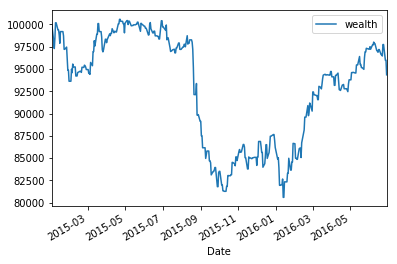

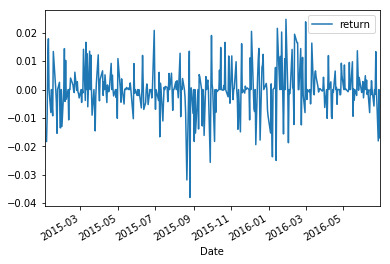

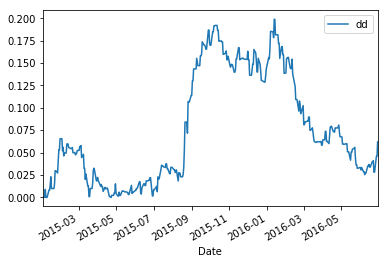

In [31]:
portfolio=create_port(test)
result_close=backtest_close(portfolio)
performance('BernoulliNB(alpha=0.5,binarize=0.0)','2-days shift, ngram_range=(1, 2), combined Top3,top12 and Top25, make decision on day i','close',result_close)

Classification method:  BernoulliNB(alpha=0.5,binarize=0.0)
Paremeters choose:  2-days shift, ngram_range=(1, 2), combined Top3,top12 and Top25, make decision on day i
Order fill type:  open
The annualized return is -3.6738%
The annualized volatility is 11.9944%
The annualized Sharpe ratio is -0.3063
The maximum drawdown during backtesting period is 20.1869%


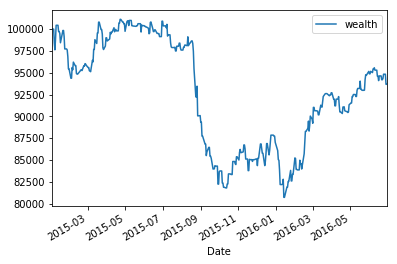

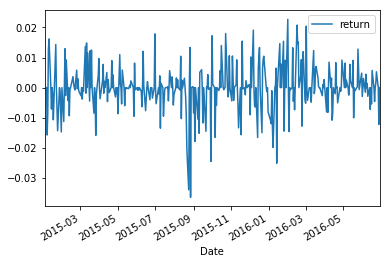

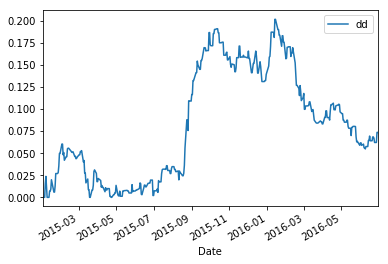

In [32]:
portfolio=create_port(test)
result_open=backtest_open(portfolio)
performance('BernoulliNB(alpha=0.5,binarize=0.0)','2-days shift, ngram_range=(1, 2), combined Top3,top12 and Top25, make decision on day i','open',result_open)

#### Strategy 2:
Accroding to the prediction for i+2, make decision on i+1

In [33]:
test.predict=test.predict.shift(1)
test.drop(test.index[0], inplace=True)

Classification method:  BernoulliNB(alpha=0.5,binarize=0.0)
Paremeters choose:  2-days shift, ngram_range=(1, 2), combined Top3,top12 and Top25, make decision on day i+1
Order fill type:  close
The annualized return is -3.4549%
The annualized volatility is 13.0726%
The annualized Sharpe ratio is -0.2643
The maximum drawdown during backtesting period is 21.6866%


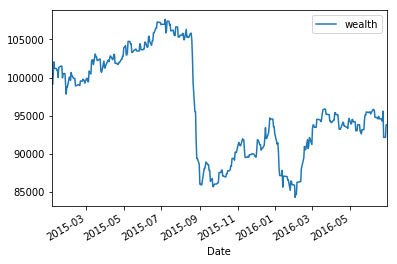

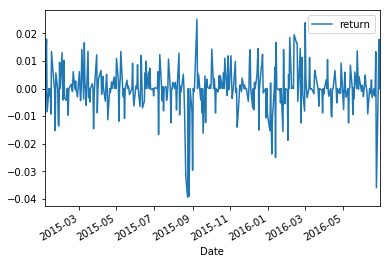

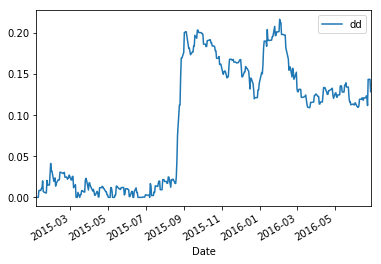

In [34]:
portfolio=create_port(test)
result_close=backtest_close(portfolio)
performance('BernoulliNB(alpha=0.5,binarize=0.0)','2-days shift, ngram_range=(1, 2), combined Top3,top12 and Top25, make decision on day i+1','close',result_close)

Classification method:  BernoulliNB(alpha=0.5,binarize=0.0)
Paremeters choose:  2-days shift, ngram_range=(1, 2), combined Top3,top12 and Top25, make decision on day i+1
Order fill type:  open
The annualized return is -3.6127%
The annualized volatility is 12.3340%
The annualized Sharpe ratio is -0.2929
The maximum drawdown during backtesting period is 21.1883%


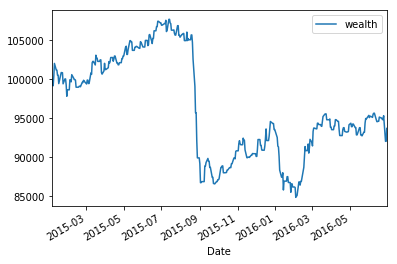

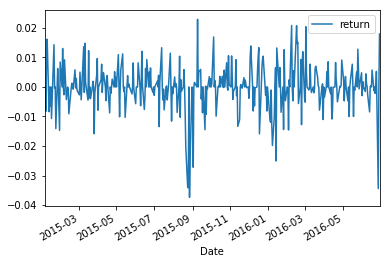

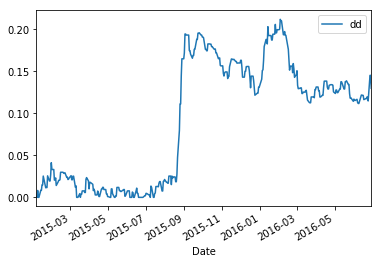

In [35]:
portfolio=create_port(test)
result_open=backtest_open(portfolio)
performance('BernoulliNB(alpha=0.5,binarize=0.0)','2-days shift, ngram_range=(1, 2), combined Top3,top12 and Top25, make decision on day i+1','open',result_open)

### Summary table for different methods

In [36]:
df_ScoreSummaryByMethod=DataFrame(ScoreSummaryByMethod,columns=['Method','Comment','ROC_AUC','Precision','Accuracy','Recall','F1'])
df_ScoreSummaryByMethod.sort_values(['ROC_AUC'],ascending=False,inplace=True)
df_FillAtClosePrice=DataFrame(FillAtClosePrice,columns=['Method','Comment','Annualized return', 'Annualized volatility', 'Annual Sharpe ratio','Maximum drawdown'])
df_FillAtClosePrice.sort_values(['Annual Sharpe ratio'],ascending=False,inplace=True)
df_FillAtOpenPrice=DataFrame(FillAtOpenPrice,columns=['Method','Comment','Annualized return', 'Annualized volatility', 'Annual Sharpe ratio','Maximum drawdown'])
df_FillAtOpenPrice.sort_values(['Annual Sharpe ratio'],ascending=False,inplace=True)

In [37]:
df_ScoreSummaryByMethod

,Method,Comment,ROC_AUC,Precision,Accuracy,Recall,F1
3,"BernoulliNB(alpha=0.5,binarize=0.0)","3-days shift, ngram_range=(1, 2), combined Top...",0.523083,0.516260,0.522667,0.679144,0.586605
2,"BernoulliNB(alpha=0.1,binarize=0.0)","1-day shift, ngram_range=(1, 2), combined Top ...",0.521320,0.511719,0.519894,0.700535,0.591422
4,"BernoulliNB(alpha=0.5,binarize=0.0)","2-days shift, ngram_range=(1, 2),Combined Top3...",0.513977,0.508475,0.513298,0.641711,0.567376
0,MultinomialNB,"no shift, no n-grams, combined Top news",0.500000,0.494709,0.494709,1.000000,0.661947
1,BernoulliNB(binarize=0.0),"default alpha=1,no shift, ngram_range=(1, 2), ...",0.450416,0.464286,0.447090,0.764706,0.577778


In [38]:
df_FillAtClosePrice

,Method,Comment,Annualized return,Annualized volatility,Annual Sharpe ratio,Maximum drawdown
3,"BernoulliNB(alpha=0.5,binarize=0.0)","3-days shift, ngram_range=(1, 2), combined Top...",0.072395,0.137092,0.528076,0.121300
2,"BernoulliNB(alpha=0.5,binarize=0.0)","3-days shift, ngram_range=(1, 2), combined Top...",0.045403,0.134076,0.338636,0.158536
4,"BernoulliNB(alpha=0.5,binarize=0.0)","2-days shift, ngram_range=(1, 2), combined Top...",-0.030518,0.131154,-0.232691,0.198852
5,"BernoulliNB(alpha=0.5,binarize=0.0)","2-days shift, ngram_range=(1, 2), combined Top...",-0.034549,0.130726,-0.264290,0.216866
0,"BernoulliNB(alpha=0.1,binarize=0.0)","1-day shift, ngram_range=(1, 2), combined Top ...",-0.053243,0.131917,-0.403614,0.191895
1,"BernoulliNB(alpha=0.5,binarize=0.0)","3-days shift, ngram_range=(1, 2), combined Top...",-0.072023,0.137231,-0.524832,0.182663


In [39]:
df_FillAtOpenPrice

,Method,Comment,Annualized return,Annualized volatility,Annual Sharpe ratio,Maximum drawdown
3,"BernoulliNB(alpha=0.5,binarize=0.0)","3-days shift, ngram_range=(1, 2), combined Top...",0.058638,0.125691,0.466529,0.119133
2,"BernoulliNB(alpha=0.5,binarize=0.0)","3-days shift, ngram_range=(1, 2), combined Top...",0.042912,0.124160,0.345617,0.149150
5,"BernoulliNB(alpha=0.5,binarize=0.0)","2-days shift, ngram_range=(1, 2), combined Top...",-0.036127,0.123340,-0.292909,0.211883
4,"BernoulliNB(alpha=0.5,binarize=0.0)","2-days shift, ngram_range=(1, 2), combined Top...",-0.036738,0.119944,-0.306290,0.201869
0,"BernoulliNB(alpha=0.1,binarize=0.0)","1-day shift, ngram_range=(1, 2), combined Top ...",-0.039241,0.122072,-0.321456,0.185950
1,"BernoulliNB(alpha=0.5,binarize=0.0)","3-days shift, ngram_range=(1, 2), combined Top...",-0.071315,0.127664,-0.558616,0.178670


## Part 3: Improvement Methods
In this part, other than the data sources problem, I proposed the following three methods to improve the results:
* Method 1: Change the weights of different top news, or try different combinations of different news
* Method 2: Use other classification algorithms such as SVM, neural network. 
* Method 3: Use more advanced NLP method instead of 'bow' and 'tfidf'

Method 1 and method 2 are examined in the following section, which suggests that neural network can proved slightly better result with AUC=0.6. Changing weights of different top news seems has no effect on AUC.

### Method 1: Try different weights of top news
I just choose the best case above, and test when triple and quadruple the weight of top25 news, the AUC remains unchanged. 
Also, from the best solution in Kaggle, I found the AUC of combining top10 and top25 news is also pretty nice, so I try the combination of top3, top10, top12, top25 news, however, the result is not good.

In [40]:
#quadruple top 25 news, 2-day shift
df=pd.read_excel('/Users/chester/Desktop/Peter_project/raw_data/Combined_News_SP500.xlsx')
df.Label = df.Label.shift(-1)
df.drop(df.index[len(df)-1], inplace=True)
df.Label = df.Label.shift(-1)
df.drop(df.index[len(df)-1], inplace=True)
df['top 25 copy1']=df['Top25']
df['top 25 copy2']=df['Top25']
df['top 25 copy3']=df['Top25']
df['Combined3_12_25*4']=df.iloc[:,[4,13,26,27,28,29]].apply(lambda row: ''.join(str(row.values)), axis=1)
train=df.loc[(pd.to_datetime(df["Date"]) <= date(2014,12,31)),['Label','Date','Combined3_12_25*4']]
test=df.loc[(pd.to_datetime(df["Date"]) > date(2014,12,31)),['Label','Date','Combined3_12_25*4']]
bnb_2ngram_pipeline.fit(train['Combined3_12_25*4'],train['Label'])
predictions = bnb_2ngram_pipeline.predict(test['Combined3_12_25*4'])
Evaluation ('BernoulliNB(alpha=0.5,binarize=0.0)','2-days shift, ngram_range=(1, 2),Combined Top3,top12 and Top25*4',test["Label"], predictions)
test['predict']=predictions
test['Date']=pd.to_datetime(test['Date'])

BernoulliNB(alpha=0.5,binarize=0.0)
2-days shift, ngram_range=(1, 2),Combined Top3,top12 and Top25*4
             precision    recall  f1-score   support

        0.0       0.52      0.39      0.44       189
        1.0       0.51      0.64      0.57       187

avg / total       0.51      0.51      0.51       376

Confussion matrix:
 [[ 73 116]
 [ 67 120]]
ROC-AUC: 0.513977308095


In [41]:
#combine top 3,10,12,25 news, 2-day shift
df=pd.read_excel('/Users/chester/Desktop/Peter_project/raw_data/Combined_News_SP500.xlsx')
df.Label = df.Label.shift(-1)
df.drop(df.index[len(df)-1], inplace=True)
df.Label = df.Label.shift(-1)
df.drop(df.index[len(df)-1], inplace=True)
df['Combined3_10_12_25']=df.iloc[:,[4,11,13,26]].apply(lambda row: ''.join(str(row.values)), axis=1)
train=df.loc[(pd.to_datetime(df["Date"]) <= date(2014,12,31)),['Label','Date','Combined3_10_12_25']]
test=df.loc[(pd.to_datetime(df["Date"]) > date(2014,12,31)),['Label','Date','Combined3_10_12_25']]
bnb_2ngram_pipeline.fit(train['Combined3_10_12_25'],train['Label'])
predictions = bnb_2ngram_pipeline.predict(test['Combined3_10_12_25'])
Evaluation ('BernoulliNB(alpha=0.5,binarize=0.0)','2-days shift, ngram_range=(1, 2),Combined Top3,top 10,top12 and Top25',test["Label"], predictions)
test['predict']=predictions
test['Date']=pd.to_datetime(test['Date'])

BernoulliNB(alpha=0.5,binarize=0.0)
2-days shift, ngram_range=(1, 2),Combined Top3,top 10,top12 and Top25
             precision    recall  f1-score   support

        0.0       0.51      0.38      0.44       189
        1.0       0.50      0.63      0.56       187

avg / total       0.50      0.50      0.50       376

Confussion matrix:
 [[ 72 117]
 [ 70 117]]
ROC-AUC: 0.503310415075


#### Method 1 Conclusion
Therefore, we may conclude that by changing weight or the combination of top news may not have much effect on the fitness of classification. The NLP procedure may not be able to capture weights feature. Too many top news may provide too much noise during the modeling process.

### Method 2: Try other classification algorithms
I tried SVM and neural network respectively. SVM has no improvement for this modeling process at least in the case of combining all top news. Neural network gives AUC of 0.52 but the parameters are hard to obtain. The following is the result of applying neural network classification. The backtesting result for neural network is the best, which can give Sharpe ratio of 0.72.

In [42]:
#try neural network
df=pd.read_excel('/Users/chester/Desktop/Peter_project/raw_data/Combined_News_SP500.xlsx')
df.Label = df.Label.shift(-1)
df.drop(df.index[len(df)-1], inplace=True)
df.Label = df.Label.shift(-1)
df.drop(df.index[len(df)-1], inplace=True)
df['Combined3_12_25']=df.iloc[:,[4,13,26]].apply(lambda row: ''.join(str(row.values)), axis=1)
train=df.loc[(pd.to_datetime(df["Date"]) <= date(2014,12,31)),['Label','Date','Combined3_12_25']]
test=df.loc[(pd.to_datetime(df["Date"]) > date(2014,12,31)),['Label','Date','Combined3_12_25']]
bnb_2ngram_pipeline = Pipeline([
    ('bow', CountVectorizer(analyzer=text_process,ngram_range=(1, 2))),
    ('tfidf', TfidfTransformer()), 
    ('classifier', MLPClassifier(solver='lbfgs', hidden_layer_sizes=(100, 1), alpha=1e-4, random_state=1))])
bnb_2ngram_pipeline.fit(train['Combined3_12_25'],train['Label'])
predictions = bnb_2ngram_pipeline.predict(test['Combined3_12_25'])
test['predict']=predictions
test['Date']=pd.to_datetime(test['Date'])
Evaluation ('MLPClassifier(alpha=1e-4,hidden_layer_size=100)','2-days shift, ngram_range=(1, 2),Combined Top3,top12 and Top25',test["Label"], predictions)

MLPClassifier(alpha=1e-4,hidden_layer_size=100)
2-days shift, ngram_range=(1, 2),Combined Top3,top12 and Top25
             precision    recall  f1-score   support

        0.0       0.53      0.38      0.44       189
        1.0       0.51      0.67      0.58       187

avg / total       0.52      0.52      0.51       376

Confussion matrix:
 [[ 71 118]
 [ 62 125]]
ROC-AUC: 0.522055286761


#### Strategy 1
Based on the prediction for day i+2, make decision on day i

Classification method:  MLPClassifier(alpha=1e-4,hidden_layer_size=100)
Paremeters choose:  2-days shift, ngram_range=(1, 2), combined Top3,top12 and Top25
Order fill type:  close
The annualized return is 9.6782%
The annualized volatility is 13.2476%
The annualized Sharpe ratio is 0.7306
The maximum drawdown during backtesting period is 14.2072%


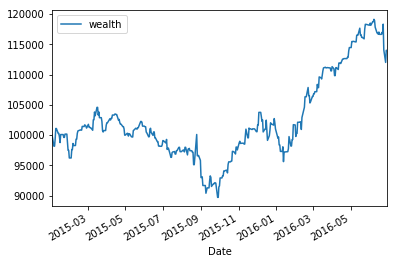

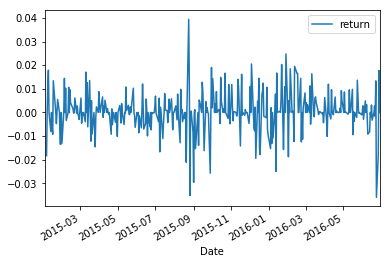

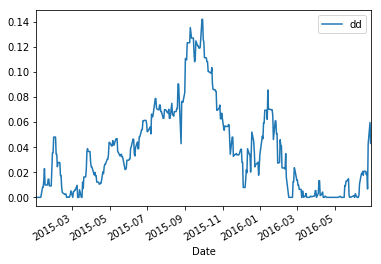

In [43]:
portfolio=create_port(test)
result_close=backtest_close(portfolio)
performance('MLPClassifier(alpha=1e-4,hidden_layer_size=100)','2-days shift, ngram_range=(1, 2), combined Top3,top12 and Top25','close',result_close)

Classification method:  MLPClassifier(alpha=1e-4,hidden_layer_size=100)
Paremeters choose:  2-days shift, ngram_range=(1, 2), combined Top3,top12 and Top25
Order fill type:  open
The annualized return is 7.6464%
The annualized volatility is 12.3282%
The annualized Sharpe ratio is 0.6202
The maximum drawdown during backtesting period is 13.8843%


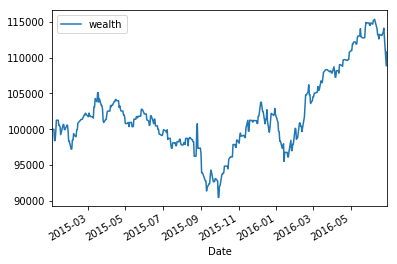

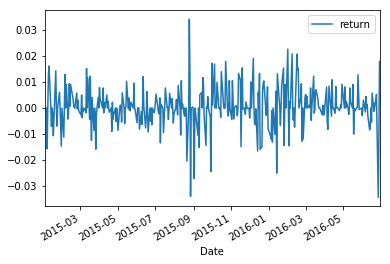

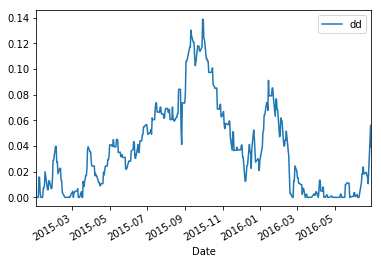

In [44]:
portfolio=create_port(test)
result_open=backtest_open(portfolio)
performance('MLPClassifier(alpha=1e-4,hidden_layer_size=100)','2-days shift, ngram_range=(1, 2), combined Top3,top12 and Top25','open',result_open)

#### Strategy 2:
Based on the prediction for day i+2, make decision on day i+1.

In [45]:
test.predict=test.predict.shift(1)
test.drop(test.index[0], inplace=True)

Classification method:  MLPClassifier(alpha=1e-4,hidden_layer_size=100)
Paremeters choose:  2-days shift, ngram_range=(1, 2), combined Top3,top12 and Top25, make decision on day i+1
Order fill type:  close
The annualized return is -3.8525%
The annualized volatility is 13.3860%
The annualized Sharpe ratio is -0.2878
The maximum drawdown during backtesting period is 15.9348%


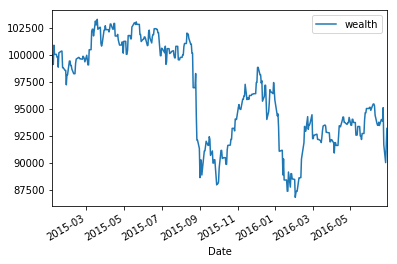

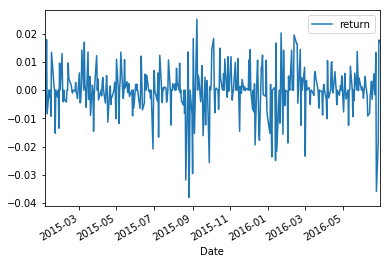

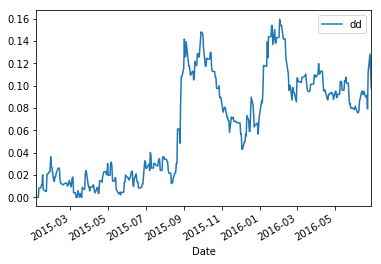

In [46]:
portfolio=create_port(test)
result_close=backtest_close(portfolio)
performance('MLPClassifier(alpha=1e-4,hidden_layer_size=100)','2-days shift, ngram_range=(1, 2), combined Top3,top12 and Top25, make decision on day i+1','close',result_close)

Classification method:  MLPClassifier(alpha=1e-4,hidden_layer_size=100)
Paremeters choose:  2-days shift, ngram_range=(1, 2), combined Top3,top12 and Top25, make decision on day i+1
Order fill type:  open
The annualized return is -4.1013%
The annualized volatility is 12.3413%
The annualized Sharpe ratio is -0.3323
The maximum drawdown during backtesting period is 14.7953%


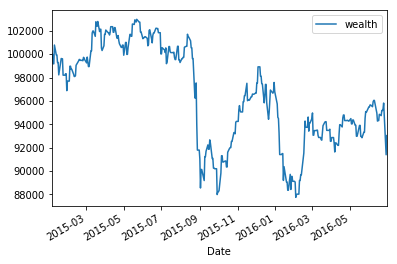

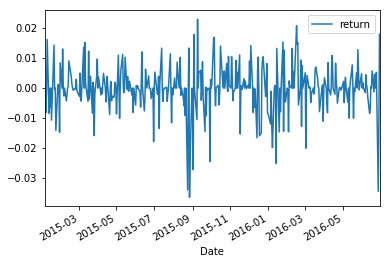

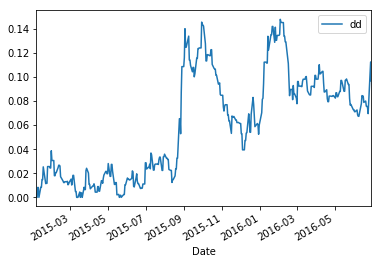

In [47]:
portfolio=create_port(test)
result_open=backtest_open(portfolio)
performance('MLPClassifier(alpha=1e-4,hidden_layer_size=100)','2-days shift, ngram_range=(1, 2), combined Top3,top12 and Top25, make decision on day i+1','open',result_open)

#### Method 2 Conclusion:
Neural network seems to provide a better AUC but the Sharpe ratio is not the best. This is because I assume short selling is not allowed, indicates that the profit from short position can not be obtained. Also, we can see the improvement is not significant, which implies that we may consider deeper, which is the NLP procedure.

### Method 3: Use more advanced NLP methods
I haven't tested this one, but I got a good reference, which focusing on neural sentiment classification. I think the method used there for NLP can be referenced and I plan to try it in stage 2.

## Summary Table Combining Improving Methods

In [48]:
df_ScoreSummaryByMethod=DataFrame(ScoreSummaryByMethod,columns=['Method','Comment','ROC_AUC','Precision','Accuracy','Recall','F1'])
df_ScoreSummaryByMethod.sort_values(['ROC_AUC'],ascending=False,inplace=True)
df_FillAtClosePrice=DataFrame(FillAtClosePrice,columns=['Method','Comment','Annualized return', 'Annualized volatility', 'Annual Sharpe ratio','Maximum drawdown'])
df_FillAtClosePrice.sort_values(['Annual Sharpe ratio'],ascending=False,inplace=True)
df_FillAtOpenPrice=DataFrame(FillAtOpenPrice,columns=['Method','Comment','Annualized return', 'Annualized volatility', 'Annual Sharpe ratio','Maximum drawdown'])
df_FillAtOpenPrice.sort_values(['Annual Sharpe ratio'],ascending=False,inplace=True)

In [49]:
df_ScoreSummaryByMethod

,Method,Comment,ROC_AUC,Precision,Accuracy,Recall,F1
3,"BernoulliNB(alpha=0.5,binarize=0.0)","3-days shift, ngram_range=(1, 2), combined Top...",0.523083,0.516260,0.522667,0.679144,0.586605
7,"MLPClassifier(alpha=1e-4,hidden_layer_size=100)","2-days shift, ngram_range=(1, 2),Combined Top3...",0.522055,0.514403,0.521277,0.668449,0.581395
2,"BernoulliNB(alpha=0.1,binarize=0.0)","1-day shift, ngram_range=(1, 2), combined Top ...",0.521320,0.511719,0.519894,0.700535,0.591422
4,"BernoulliNB(alpha=0.5,binarize=0.0)","2-days shift, ngram_range=(1, 2),Combined Top3...",0.513977,0.508475,0.513298,0.641711,0.567376
5,"BernoulliNB(alpha=0.5,binarize=0.0)","2-days shift, ngram_range=(1, 2),Combined Top3...",0.513977,0.508475,0.513298,0.641711,0.567376
6,"BernoulliNB(alpha=0.5,binarize=0.0)","2-days shift, ngram_range=(1, 2),Combined Top3...",0.503310,0.500000,0.502660,0.625668,0.555819
0,MultinomialNB,"no shift, no n-grams, combined Top news",0.500000,0.494709,0.494709,1.000000,0.661947
1,BernoulliNB(binarize=0.0),"default alpha=1,no shift, ngram_range=(1, 2), ...",0.450416,0.464286,0.447090,0.764706,0.577778


In [50]:
df_FillAtClosePrice

,Method,Comment,Annualized return,Annualized volatility,Annual Sharpe ratio,Maximum drawdown
6,"MLPClassifier(alpha=1e-4,hidden_layer_size=100)","2-days shift, ngram_range=(1, 2), combined Top...",0.096782,0.132476,0.730562,0.142072
3,"BernoulliNB(alpha=0.5,binarize=0.0)","3-days shift, ngram_range=(1, 2), combined Top...",0.072395,0.137092,0.528076,0.121300
2,"BernoulliNB(alpha=0.5,binarize=0.0)","3-days shift, ngram_range=(1, 2), combined Top...",0.045403,0.134076,0.338636,0.158536
4,"BernoulliNB(alpha=0.5,binarize=0.0)","2-days shift, ngram_range=(1, 2), combined Top...",-0.030518,0.131154,-0.232691,0.198852
5,"BernoulliNB(alpha=0.5,binarize=0.0)","2-days shift, ngram_range=(1, 2), combined Top...",-0.034549,0.130726,-0.264290,0.216866
7,"MLPClassifier(alpha=1e-4,hidden_layer_size=100)","2-days shift, ngram_range=(1, 2), combined Top...",-0.038525,0.133860,-0.287804,0.159348
0,"BernoulliNB(alpha=0.1,binarize=0.0)","1-day shift, ngram_range=(1, 2), combined Top ...",-0.053243,0.131917,-0.403614,0.191895
1,"BernoulliNB(alpha=0.5,binarize=0.0)","3-days shift, ngram_range=(1, 2), combined Top...",-0.072023,0.137231,-0.524832,0.182663


In [51]:
df_FillAtOpenPrice

,Method,Comment,Annualized return,Annualized volatility,Annual Sharpe ratio,Maximum drawdown
6,"MLPClassifier(alpha=1e-4,hidden_layer_size=100)","2-days shift, ngram_range=(1, 2), combined Top...",0.076464,0.123282,0.620236,0.138843
3,"BernoulliNB(alpha=0.5,binarize=0.0)","3-days shift, ngram_range=(1, 2), combined Top...",0.058638,0.125691,0.466529,0.119133
2,"BernoulliNB(alpha=0.5,binarize=0.0)","3-days shift, ngram_range=(1, 2), combined Top...",0.042912,0.124160,0.345617,0.149150
5,"BernoulliNB(alpha=0.5,binarize=0.0)","2-days shift, ngram_range=(1, 2), combined Top...",-0.036127,0.123340,-0.292909,0.211883
4,"BernoulliNB(alpha=0.5,binarize=0.0)","2-days shift, ngram_range=(1, 2), combined Top...",-0.036738,0.119944,-0.306290,0.201869
0,"BernoulliNB(alpha=0.1,binarize=0.0)","1-day shift, ngram_range=(1, 2), combined Top ...",-0.039241,0.122072,-0.321456,0.185950
7,"MLPClassifier(alpha=1e-4,hidden_layer_size=100)","2-days shift, ngram_range=(1, 2), combined Top...",-0.041013,0.123413,-0.332327,0.147953
1,"BernoulliNB(alpha=0.5,binarize=0.0)","3-days shift, ngram_range=(1, 2), combined Top...",-0.071315,0.127664,-0.558616,0.178670


In [52]:
df_FillAtClosePrice.to_excel("/Users/chester/Desktop/Peter_project/output/SP500_long_short/fill_at_close.xlsx",index=False)
df_FillAtOpenPrice.to_excel("/Users/chester/Desktop/Peter_project/output/SP500_long_short/fill_at_open.xlsx",index=False)